# **Israel Elections Data Analysis - Lab 8**


**Daniel Ohayon - ID: 315453027**

**Olga Moroz - ID: 324756568**

### **Import modules**

In [1]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
import math
import os
import io
from matplotlib import pyplot as plt
import numpy.matlib as mtl
import copy
import random
import statsmodels.api as sm
from sklearn.preprocessing import normalize
import warnings
import seaborn as sns; sns.set_theme()
import scipy
warnings.filterwarnings('ignore')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Import data**

In [2]:
# Mount drive in google colab
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
# Loading elections 2020 elections data:
from google.colab import files
uploaded = files.upload()


Saving votes per ballot 2019b.csv to votes per ballot 2019b.csv
Saving votes per ballot 2020.csv to votes per ballot 2020.csv


In [4]:
df_2020_ballot_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2020_ballot_raw['שם ישוב'] = df_2020_ballot_raw.index
df_2020_ballot_raw = df_2020_ballot_raw.drop(['מעטפות חיצוניות'], axis=0)
df_2019_ballot_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2019b.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2019_ballot_raw['שם ישוב'] = df_2019_ballot_raw.index
df_2019_ballot_raw = df_2019_ballot_raw.drop(['מעטפות חיצוניות'], axis=0)

**:בניית מילון לשמות המפלגות**

In [5]:
party_dict20 = { "מחל" : "הליכוד", "פה" : "כחול לבן", "ודעם" : "הרשימה המשותפת" , "שס" : "שס" ,
               "ג" : "יהדות התורה", "ל" : "ישראל ביתנו", "אמת" :  "העבודה גשר מרצ",  "טב" : "ימינה", "נץ":"עוצמה יהודית" }

par_names20 = list(party_dict20.values())

In [6]:
party_dict19 = {"מחל" : "הליכוד" ,"פה" : "כחול לבן" ,  "ודעם" : "הרשימה המשותפת" , "שס" : "שס",
                "ג" : "יהדות התורה" ,"ל" : "ישראל ביתנו" ,  "אמת" : "העבודה גשר" ,
                 "מרצ" : "המחנה הדמוקרטי", "טב" : "ימינה", "כף" : "עוצמה יהודית"}

par_names19 = list(party_dict19.values())

שמות המפלגות לגרפים

In [7]:
rev_names19 = [name[::-1] for name in list(party_dict19.values())]
rev_names20 = [name[::-1] for name in list(party_dict20.values())]

**פונקציה למציאת הקלפיות המשותפות בין מערכות הבחירות**

In [8]:
# Change dataframe to include unique index for each ballot. From Harel Cain
def adapt_df(df, parties, include_no_vote=False, ballot_number_field_name=None):
    df['ballot_id'] = df['סמל ישוב'].astype(str) + '__' + df[ballot_number_field_name].astype(str)
    df_yeshuv = df.index  # new: keep yeshuv
    df = df.set_index('ballot_id')
    eligible_voters = df['בזב']
    total_voters = df['מצביעים']
    df = df[parties]
    df['ישוב'] = df_yeshuv  # new: keep yeshuv
    df = df.reindex(sorted(df.columns), axis=1)
    if include_no_vote:
        df['לא הצביעו'] = eligible_voters - total_voters
    return df

**פונקציה ליצירת מפת חום**

In [9]:
def heatmap_plot(m_hat, str_title):
  fig, ax = plt.subplots(figsize =(9,7))
  sns.heatmap(m_hat ,xticklabels=rev_names20, yticklabels=rev_names19, annot=True)
  ax.set_xlabel("Parties 2020")
  ax.set_ylabel("Parties 2019")
  plt.setp(ax.get_xticklabels(), rotation=60, ha="right",rotation_mode="anchor")
  ax.set_title(str_title)

**פונקציה לגרף עמודות**

In [10]:
def parties_bar(df):
    width = 0.3

    votes = df.sum(axis = 0).sort_values(ascending=False)
    n = len(votes)  # number of parties

    names = votes.keys()
    names_d = copy.deepcopy(party_dict20)
    names_d["לא הצביעו"] = "לא הצביעו"

    rev_names = [names_d[name][::-1] for name in list(names)]
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.bar(np.arange(n), list(votes), width, color='g')

    ax.set_ylabel('Average Squared Residual Sum')
    ax.set_xlabel('Parties Names')
    ax.set_title('Average Squared Residual Sum per Party')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(rev_names, rotation = 60, size = 8)

    plt.show()

# **Q.1:**

### **A.**

מציאת הקלפיות המשותפות והשארת העמודות הרלוונטיות מכל מערכת בחירות

In [11]:
# Match ballots for 2 elections
b2019 = adapt_df(df_2019_ballot_raw, list(party_dict19.keys()), include_no_vote=False, ballot_number_field_name='קלפי')
b2020 = adapt_df(df_2020_ballot_raw, list(party_dict20.keys()), include_no_vote=False, ballot_number_field_name='קלפי')
u = pd.merge(b2019, b2020, how='inner', left_index=True, right_index=True)
n_a1= b2019.loc[u.index][party_dict19]
n_b1 = b2020.loc[u.index][party_dict20]  # these dataframes contain number of votes for the two elections only in shared ballots

מציאת מטריצת המעבר-M_hat

In [12]:
m1 = np.linalg.inv(np.transpose(n_a1).dot(n_a1))
m2 = np.transpose(n_a1).dot(n_b1)
m_hat1 = m1.dot(m2)

m_hat1 = pd.DataFrame(data=m_hat1)
m_hat1.columns = list(party_dict20.keys())

**Heatmap of m_hat**

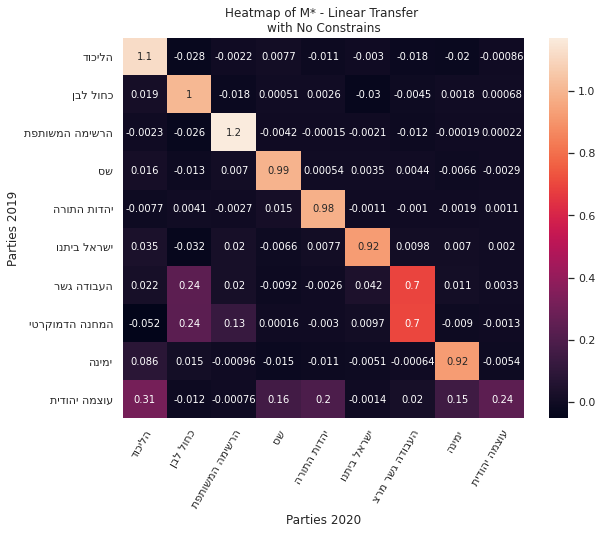

In [13]:
heatmap_plot(m_hat1,"Heatmap of M* - Linear Transfer \nwith No Constrains")

### **B.**

איפוס כל ערך המטריצת המעבר שקטן מ-0.5% ונרמול השורות כך שסכום כל שורה יהיה 1

In [14]:
m_hat1[m_hat1<0.005] = 0
m_hat1 = m_hat1.div(m_hat1.sum(axis=1),axis=0)

**Heatmap of m_hat**

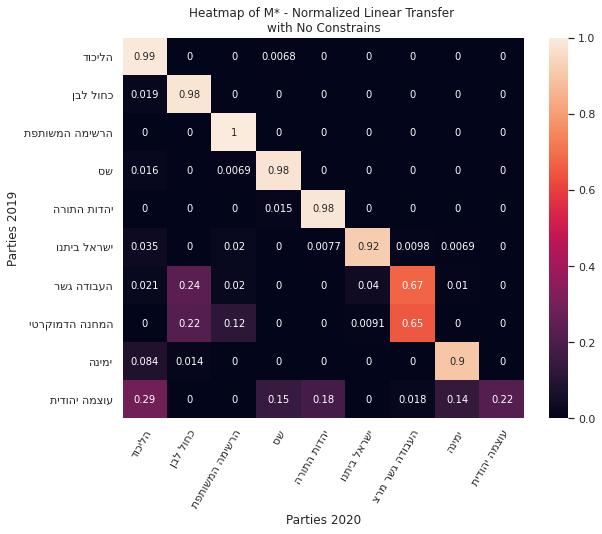

In [15]:
heatmap_plot(m_hat1, "Heatmap of M* - Normalized Linear Transfer \nwith No Constrains")

**:ניתוח מפות החום**

בעזרת שיטת הריבועים הפחותים חישבנו את מטריצות המעבר בין בחירות ספטמבר 19 לבחירות מרץ 20.

במטריצת המעבר בסעיף ב' איפסנו ערך שהיה קטן מחצי אחוז ונרמלנו את השורות כך שסכום כל שורה יהיה 1.

ניתן לראות שאיחוד המפלגות- העבודה גשר והמחנה הדמוקרטי שרצו בנפרד בבחירות בספטמבר הגדיל את כוחן הכולל של המפלגות כשרצו יחד כמפלגה אחת בבחירות 20.

בנוסף ניתן לראות שהמשבצת שמסמלת את הישארות המצביעים בעוצמה יהודית בשתי מערכות הבחירות יחסית כהה ביחס למשבצות המקבילות של שאר המפלגות, דבר שמעיד על כך שמצביעים רבים בחרו לעבור מעוצמה יהודית למפלגות אחרות ב2020.
את חלקם של אותם מצביעים ניתן לראות במשבצות הסגולות הבהירות שמשותפות לעוצמה יהודית ב2019 עם הליכוד, שס, ימינה ויהדות התורה ב-2020. כלומר חלק יחסית נכבד ממצביעי עוצמה יהודית בספטמבר 19, עברו בבחירות 2020 להצביע למלפגות אחרות.

כנ"ל לגבי מעבר ממפלגות השמאל- חלק ממצביעי העבודה-גשר והמחנה הדמוקרטי שעברו להצביע לכחול לבן במרץ 2020.

# **Q.2:**

מציאת הקלפיות המשותפות והשארת העמודות הרלוונטיות מכל מערכת בחירות

In [16]:
b2019 = adapt_df(df_2019_ballot_raw, list(party_dict19.keys()), include_no_vote=True, ballot_number_field_name='קלפי')
b2020 = adapt_df(df_2020_ballot_raw, list(party_dict20.keys()), include_no_vote=True, ballot_number_field_name='קלפי')
u = pd.merge(b2019, b2020, how='inner', left_index=True, right_index=True)
col19 = list(party_dict19.keys()) + ["לא הצביעו"]
col20 = list(party_dict20.keys()) + ["לא הצביעו"]
n_a2 = b2019.loc[u.index][col19]
n_b2 = b2020.loc[u.index][col20] # these dataframes contain number of votes for the two elections only in shared ballots


חישוב מטריצת המעבר- M_hat

In [17]:
m1 = np.linalg.pinv(np.transpose(n_a2).dot(n_a2))
m2 = np.transpose(n_a2).dot(n_b2)
m_hat2 = m1.dot(m2)
m_hat2[m_hat2<0.005] = 0

m_hat2 = pd.DataFrame(data=m_hat2)
m_hat2 = m_hat2.div(m_hat2.sum(axis=1),axis=0)
m_hat2.columns = list(party_dict20.keys()) + ["לא הצביעו"]

Heatmap of M_hat

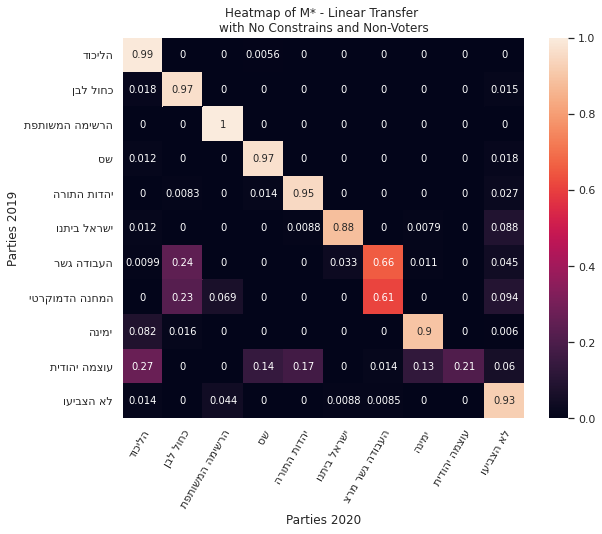

In [18]:
rev_names19 = [name[::-1] for name in list(party_dict19.values())+["לא הצביעו"]]
rev_names20 = [name[::-1] for name in list(party_dict20.values())+["לא הצביעו"]]
heatmap_plot(m_hat2,"Heatmap of M* - Linear Transfer \nwith No Constrains and Non-Voters")

**:ניתוח מפת החום**

חישבנו את מטריצת המעבר פעם נוספת, אך הפעם התייחסנו גם לאולוסיית בעלי זכות בחירה שהחליטו לא להצביע.
אותם בז"ב שלא הצביעו נחשבים כבוחרים למפלגת-"לא לבחור". וכך למעשה הגדרנו את המפלגה החדשה "לא להצביע" בפונקציה שבה השתמשנו.

נראה שיש הבדל מזערי בין הלא מצביעים בשתי מערכות הבחירות. 
כך שבאופן כללי בז"ב שהחליטו לא להצביע בבחירות ספטמבר 19 המשיכו באותה מגמה ובחרו שלא להצביע גם בבחירות 2020.
כמו כן, כשהוספנו את עמודת ה"לא הצביעו" ניתן לראות שישנה ירידה קלה במשבצות שעל האלכסון של ישראל ביתנו, יהדות התורה ושס, ומנגד עלייה קלה במשבצות המשותפות של אותן מפלגות ב2019 עם "לא להצביע" ב-2020.
כלומר, ניתן להניח שחלק קטן ממצביעי אותן מפלגות ב2019, בחרו ב-2020 שלא להצביע בכלל.

# **Q.3:**

מציאת הקלפיות המשותפות והשארת העמודות הרלוונטיות מכל מערכת בחירות

In [19]:
b2019 = adapt_df(df_2019_ballot_raw, list(party_dict19.keys()), include_no_vote=False, ballot_number_field_name='קלפי')
b2020 = adapt_df(df_2020_ballot_raw, list(party_dict20.keys()), include_no_vote=False, ballot_number_field_name='קלפי')
u = pd.merge(b2019, b2020, how='inner', left_index=True, right_index=True)
n_a3 = b2019.loc[u.index][party_dict19]
n_b3 = b2020.loc[u.index][party_dict20]
n_a3 = n_a3.values
n_b3 = n_b3.values

חישוב מטריצת המעבר עם אילוצי החיוביות - **איברי מטריצה לא יכולים להיות שליליים** וגם הפעם סכום כל שורה הוא 1

In [20]:
m_hat3 = np.zeros((n_a3.shape[1], n_b3.shape[1]))

for i in range(n_b3.shape[1]):
    sol, r2 = scipy.optimize.nnls(n_a3, n_b3[:, i])
    m_hat3[:,i] = sol

m_hat3[m_hat3<0.005] = 0
m_hat3 = pd.DataFrame(data=m_hat3)
m_hat3 = m_hat3.div(m_hat3.sum(axis=1),axis=0)
m_hat3.columns = list(party_dict20.keys())

Heatmap of M_hat

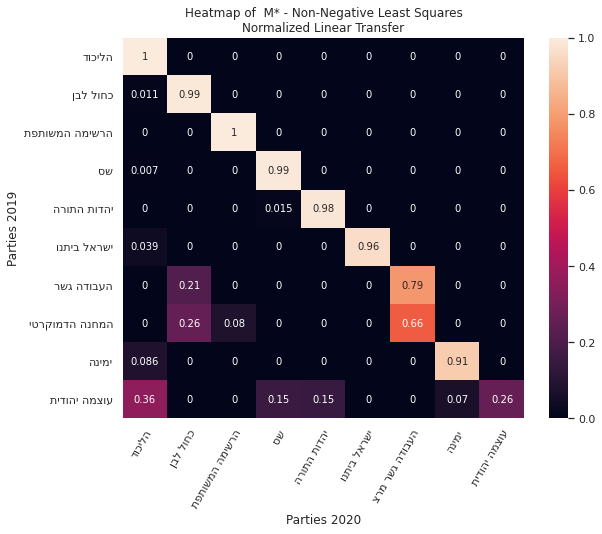

In [21]:
rev_names19 = [name[::-1] for name in list(party_dict19.values())]
rev_names20 = [name[::-1] for name in list(party_dict20.values())]
heatmap_plot(m_hat3,"Heatmap of  M* - Non-Negative Least Squares\nNormalized Linear Transfer")

הפעם חישבנו את מטריצת המעבר פעם נוספת אך הפעם התייחסנו לאילוצים לפני החישוב- הגדרנו כי איברי מטריצת המעבר לא יכולים להיות שליליים וגם הפעם סכום כל שורה הוא 1.

היתרון במודל זה לעומת איפוס הערכים הקטנים והשלילייים הוא שנקבל דיוק יותר גבוה. האילוץ מתקיים בשני המקרים אך הערך המינימלי ביותר של המרחק שהגדרנו יתקבל כמינימום קטן/שווה למינימום הקודם שמצאנו.

נראה כי לא קיים שינוי משמעותי בעקבות אילוצי החיוביות- מפת החום נראית כמעט זהה בין המקרה המנורמל ללא אילוצי החיוביות לבין המקרה המנורצל עם האילוצים. השינוים הם רק בעשירית האחוז.
חשוב כמובן להדגיש, שבסדרי גודל כאלה אמנם השינויים קטנים אך עדיין מדובר במעבר בפועל של קולות בין המפלגות, ולכן עדיין יש לייחס לכך חשיבות כלשהי.

# **Q.4:**

מציאת הקלפיות המשותפות והשארת העמודות הרלוונטיות מכל מערכת בחירות

In [22]:
n_a4 = n_a2.values
n_b4 = n_b2.values # these dataframes contain number of votes for the two elections only in shared ballots

חישוב מטריצת המעבר והשגיאה של כל קלפי עבור כל מפלגה 

In [23]:
m_res = {}
for i in range(n_b4.shape[1]):
    sol, r2 = scipy.optimize.nnls(n_a4, n_b4[:, i])
    res = (n_a4 @ sol) - n_b4[:, i]
    m_res[n_b2.keys()[i]] = np.mean(res**2)

for k in m_res:
    m_res[k] = [m_res[k]]

m_res = pd.DataFrame(m_res)

הצגת גרף העמודות של השגיאה הריבועית הממוצעת לכל מפלגה

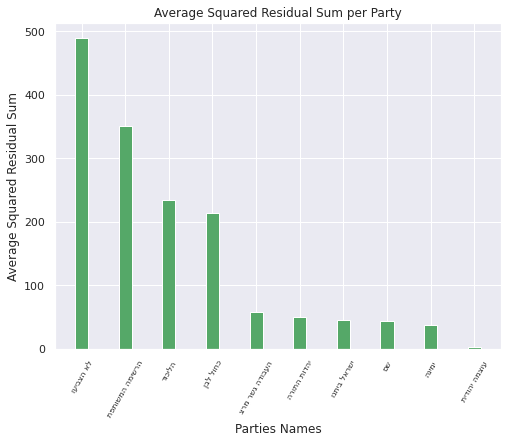

In [24]:
parties_bar(m_res)

חישבנו את השגיאה של כל קלפי עבור כל מפלגה ואז בעזרת התוצאות חישבנו את השגיאה הריבועית הממוצעת (ממוצע ריבועי השגיאות) של כל מפלגה.

ניתן לראות בגרף שברוב מוחלט של המפלגות המודל הצליח לחזות באופן טוב יותר את אחוז המעבר בין המפלגות השונות, אך עבור הבוחרים שלא הצביעו קיבלנו שגיאה ריבועית חריגה ביחס לשאר המפלגות.

בנוסף, גם השגיאה הריבועית של הרשימה המשותפת, הליכוד וכחול לבן מאוד גבוהה.

בנוגע ל"מפלגת-לא הצביעו" ניתן לקבל את ההשערה כי אלו שהצביעו בבחירות כלשהן ויחליטו בבחירות הבאות גם להצביע ולהיפך, משני טעמים: טעמים פרקטיים- הימצאות בחו"ל בזמן בחירות של אחד המועדים, או טעמים פוליטיים- בבחירות הראשונות האימנו שהמפלגה שהם תומכים בה לא תקבל מספיק תמיכה אך נראה שהם כן הצליחו אז בבחירות השניות הם ישקיעו מזמנם ויצביעו.

גם לגבי הרשימה המשותפת ניתן לשער מספר אפשרויות: באוכלוסיהה הערבית ישנה התנגדות להצבעה באופן כללי במדינת ישראל, יתכן שהרשימה המשותפת הצליחה לשכנע את ראשי היישובים כן להצביע בבחירות או שאולי ישנם אי סדרים כלשהם בבחירות, כמו שמצאנו למשל במעבדה 6.
